<a href="https://colab.research.google.com/github/TheCrypted/STAT-4830-project-base/blob/main/notebooks/notebook_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 2.0 MB/s eta 0:00:00


In [5]:
import osmnx as ox
import matplotlib.pyplot as plt

def get_city_roads(city_name, network_type='drive'):
    # Configure OSMnx using settings
    ox.settings.use_cache = True
    ox.settings.log_console = True

    try:
        # Download street network
        G = ox.graph_from_place(city_name, network_type=network_type)

        # Convert to GeoDataFrame
        nodes, edges = ox.graph_to_gdfs(G)

        # Basic stats
        print(f"Number of nodes: {len(nodes)}")
        print(f"Number of edges: {len(edges)}")

        # Plot the street network
        fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)
        plt.show()

        return G, nodes, edges

    except Exception as e:
        print(f"Error fetching data: {str(e)}")
        return None, None, None



Number of nodes: 201
Number of edges: 566


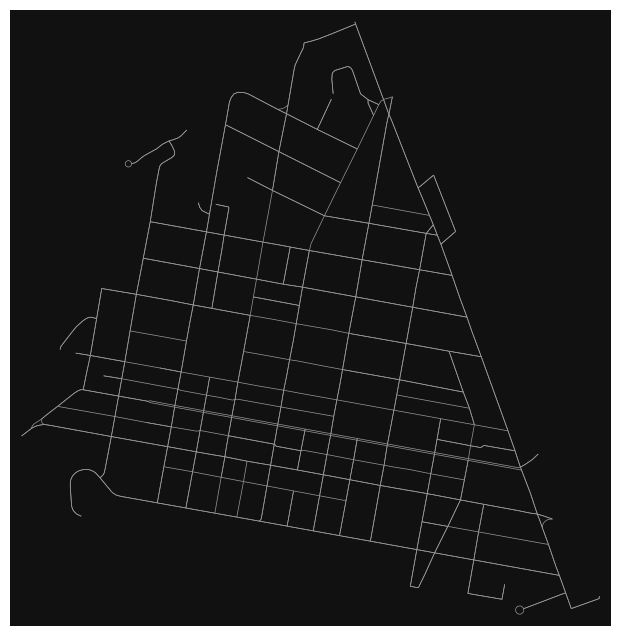


=== Basic Network Statistics ===
Total length of network: 30378.56 meters
Average street length: 93.47 meters
Number of intersections: 201
Number of street segments: 566

=== Road Types Distribution ===
highway
residential      419
primary           80
tertiary          60
living_street      5
primary_link       1
tertiary_link      1
Name: count, dtype: int64

=== Sample Edge Data ===
                             osmid      highway                   name  \
u         v         key                                                  
109756437 109988582 0    608248650  residential   West Franklin Street   
          109756448 0    608248651  residential      South Plum Street   
109756448 109868755 0     12119024  residential  West Jefferson Street   

                         oneway reversed      length  \
u         v         key                                
109756437 109988582 0      True    False   67.149378   
          109756448 0      True    False  106.564177   
109756448 10986

In [6]:
import pandas as pd
import folium

def inspect_network(G, nodes, edges):
    """Inspect the road network data in different ways"""

    # 1. Basic Network Statistics
    print("\n=== Basic Network Statistics ===")
    stats = ox.basic_stats(G)
    print(f"Total length of network: {stats['street_length_total']:.2f} meters")
    print(f"Average street length: {stats['street_length_avg']:.2f} meters")
    print(f"Number of intersections: {len(nodes)}")
    print(f"Number of street segments: {len(edges)}")

    # 2. Edge Types Analysis
    print("\n=== Road Types Distribution ===")
    if 'highway' in edges.columns:
        road_types = edges['highway'].value_counts()
        print(road_types)

    # 3. Sample of Edge Data
    print("\n=== Sample Edge Data ===")
    print(edges.head(3))

    # 4. Node Coordinates Sample
    print("\n=== Sample Node Coordinates ===")
    print(nodes[['y', 'x']].head(3))  # y is lat, x is lon

    # 5. Create an interactive map
    center_point = (nodes['y'].mean(), nodes['x'].mean())
    m = folium.Map(location=center_point, zoom_start=14)

    # Add edges to the map
    for idx, row in edges.iterrows():
        if row.geometry:
            locations = [(lat, lon) for lon, lat in row.geometry.coords]
            folium.PolyLine(
                locations=locations,
                weight=2,
                color='blue',
                opacity=0.8
            ).add_to(m)

    # Save the map
    m.save('road_network.html')

    return stats

def analyze_road_attributes(edges):
    """Analyze specific road attributes"""

    print("\n=== Road Attributes Analysis ===")

    # Available attributes
    print("Available attributes:", edges.columns.tolist())

    # Analyze specific attributes if they exist
    attributes_to_check = ['highway', 'lanes', 'maxspeed', 'oneway', 'surface']

    for attr in attributes_to_check:
        if attr in edges.columns:
            print(f"\n{attr.upper()} Distribution:")
            print(edges[attr].value_counts().head())

def find_important_nodes(G, nodes):
    """Find important intersections based on degree centrality"""

    print("\n=== Important Intersections ===")

    # Calculate node degrees (number of connected streets)
    node_degrees = dict(G.degree())

    # Find nodes with highest degrees (major intersections)
    important_intersections = sorted(node_degrees.items(),
                                  key=lambda x: x[1],
                                  reverse=True)[:5]

    print("Top 5 intersections by number of connected streets:")
    for node_id, degree in important_intersections:
        coords = nodes.loc[node_id]
        print(f"Node {node_id}: {degree} connections at ({coords['y']:.4f}, {coords['x']:.4f})")

# Usage example
city = "Media, Pennsylvania, USA"
G, nodes, edges = get_city_roads(city)

if G is not None:
    # Run all inspections
    stats = inspect_network(G, nodes, edges)
    analyze_road_attributes(edges)
    find_important_nodes(G, nodes)

    # Additional specific queries
    print("\n=== Specific Queries ===")

    # Find longest road segment
    if 'length' in edges.columns:
        longest_road = edges.sort_values('length', ascending=False).iloc[0]
        print(f"\nLongest road segment: {longest_road['length']:.2f} meters")
        if 'name' in edges.columns and longest_road['name']:
            print(f"Road name: {longest_road['name']}")

    # Calculate total network length by road type
    if 'highway' in edges.columns and 'length' in edges.columns:
        length_by_type = edges.groupby('highway')['length'].sum()
        print("\nTotal length by road type (meters):")
        print(length_by_type)
